# 動く物体の条件を解析的に発見する

In [1]:

%cd /data3/yokoyama/labvideo
import os
import sys
import shutil
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml

sys.path.append(".")
from src.utils import json_handler, video, yaml_handler

/data3/yokoyama/labvideo


/data3/yokoyama/anaconda3/envs/labvideo/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
video_name = "Failures10"
yolo_preds = np.loadtxt(
    f"out/{video_name}/{video_name}_det_finetuned.tsv", skiprows=1, dtype=float
)

In [3]:
yolo_preds[0]

array([  0.      , 596.600586, 494.290527, 610.333008, 533.380005,
         0.835266,   0.      ,   1.      ,   0.      ,   0.      ])

In [4]:
yolo_preds_append_diff = np.hstack([yolo_preds, np.zeros((len(yolo_preds), 1))])

In [5]:
pre_objects = {}
bbox_diffs = []
for i, pred in enumerate(yolo_preds_append_diff):
    n_frame = int(pred[0])
    bbox = pred[1:5].astype(np.float32)
    label = int(pred[6])
    tid = int(pred[7])

    if tid not in pre_objects:
        pre_objects[tid] = (n_frame, bbox, label)
        continue

    if n_frame - pre_objects[tid][0] > 1:
        del pre_objects[tid]
        continue
    if label != pre_objects[tid][2]:
        del pre_objects[tid]
        continue

    diff = bbox - pre_objects[tid][1]
    cx, cy = diff.reshape(2, 2).mean(axis=0)
    c_diff = np.sqrt(cx**2 + cy**2)
    bbox_diffs.append(c_diff)
    yolo_preds_append_diff[i, -1] = c_diff

    pre_objects[tid] = (n_frame, bbox, label)

bbox_diffs = np.array(bbox_diffs)

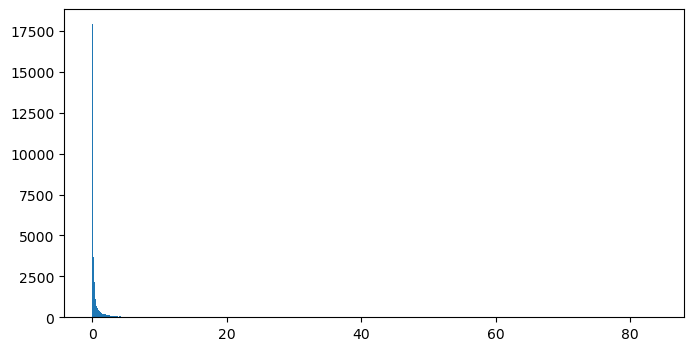

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(bbox_diffs, bins=1000)
plt.show()

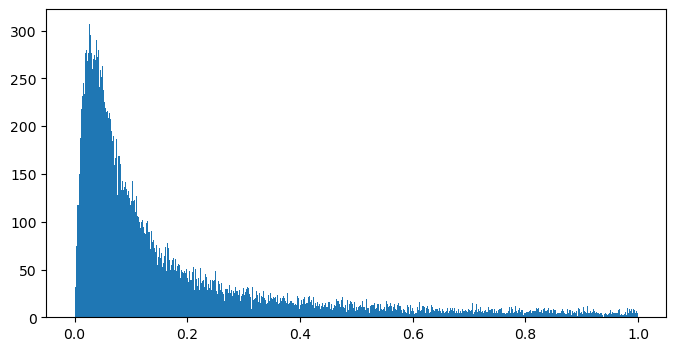

In [7]:
plt.figure(figsize=(8, 4))
plt.hist(bbox_diffs, bins=1000, range=(0, 1))
plt.show()

# 大津法による閾値

In [8]:
# Define Otsu scoring function
def otsu_score(data, thresh):
    w_0 = np.sum(data <= thresh) / data.shape[0]
    w_1 = np.sum(data > thresh) / data.shape[0]
    # check ideal case
    if (w_0 == 0) | (w_1 == 0):
        return 0
    mean_all = data.mean()
    mean_0 = data[data <= thresh].mean()
    mean_1 = data[data > thresh].mean()
    sigma2_b = w_0 * ((mean_0 - mean_all) ** 2) + w_1 * ((mean_1 - mean_all) ** 2)

    return sigma2_b


# Callculation of Otsu score and analyze the optimal
scores_otsu = np.zeros(int(np.max(bbox_diffs)) * 10)
for i in range(scores_otsu.shape[0]):
    scores_otsu[i] = otsu_score(bbox_diffs, i / 10)
thresh_otsu = np.argmax(scores_otsu) / 10
thresh_otsu

4.2